In [3]:
import pandas as pd
import arviz as az
import pymc3 as pm
import numpy as np 

In [90]:
#载入数据
data = pd.read_csv("data/TrainSet.csv")

In [70]:
data.head(10)
#发现问题：1.变量命名比较混乱 2.自变量需要清洗出来，需重新编码 3.被试的信息比较混乱，且有大量的缺失值需要处理，大小写也不统一

,Unnamed: 0,language,user_id,trait,stim_id,order,rt,rating,country,sex,age,ethnicity.x,lab,block,X,Race,Gender,Age,ethnicity.y,gender
0,606711,SPA,9654,confident,BM-040,41,1903,3,CO,f,18.0,NaN,COL_004,2,51,B,M,26.952381,black,male
1,331376,HU,5381,responsible,WF-015,33,799,7,HU,f,26.0,"magyar, kaukázusi",HUN_001,2,93,W,F,24.211111,white,female
2,162777,ENG,2734,attractive,LF-208,14,1226,1,US,f,32.0,Hispanic,USA_038,2,63,L,F,24.642857,latinx,female
3,614094,SPA,9753,caring,BF-008,67,4561,7,CO,f,22.0,ninguno,COL_004,1,35,B,F,24.574713,black,female
4,732055,PT,11726,aggressive,BF-201,36,912,3,PT,f,20.0,Caucasiana,POR_001,2,40,B,F,27.400000,black,female
5,353796,ENG,5692,attractive,BF-047,105,1446,1,AU,m,24.0,Caucasian,AUS_007,1,39,B,F,34.213483,black,female
6,437062,ENG,6884,mean,WM-256,73,1991,1,CA,f,19.0,South Asian,CAN_018,1,120,W,M,30.961538,white,male
7,88967,ENG,1541,old,BF-004,3,1437,4,US,f,18.0,White,USA_113,2,32,B,F,26.983696,black,female
8,438455,ENG,6897,caring,LM-243,63,2546,6,CA,m,20.0,white,CAN_018,2,86,L,M,21.642857,latinx,male
9,701944,ENG,11134,aggressive,LM-219,13,1629,2,US,f,21.0,white,USA_054,1,81,L,M,26.703704,latinx,male


In [108]:
#重新命名方便理解
data = data.rename(columns = {'ethnicity.x':'ethnicity_participants','ethnicity.y':'ethnicity_face'})
#利用dropna函数对某一列中的缺失值进行处理https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
data = data.dropna(subset = ['ethnicity_participants'])
#将被试的ethnicity全部变为小写
data['ethnicity_participants'] = data['ethnicity_participants'].str.lower()
#新建一列开始编码自变量
data['independent_variable']=1
#首先研究白人是否会对白人面孔有更快的反应时
    #遇到了问题：ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.an  
    #出现此错误是因为Python的逻辑运算符(and、or、not)是用来与布尔值（boolean）一起使用的，所以当试图将它们与序列或数组一起使用时，系统程序不清楚如何确定它是真的还是假的，因此会导致ValueError。
    #这篇博客指出了dataframe的返回规则，并且提出可以使用isin函数: https://zhuanlan.zhihu.com/p/475693888
a=['white','caucaisan']
b=['white']
data.loc[(data['ethnicity_participants'].isin(a)) & (data['ethnicity_face'].isin(b)), 'independent_variable']='0'
#筛选出我们想要的被试数据： https://www.cnblogs.com/silentteller/p/10871944.html
data_analysis = data[data['ethnicity_participants'].isin(a)]

In [110]:
data_analysis.head(20)

,Unnamed: 0,language,user_id,trait,stim_id,order,rt,rating,country,sex,...,ethnicity_participants,lab,block,X,Race,Gender,Age,ethnicity_face,gender,independent_variable
7,88967,ENG,1541,old,BF-004,3,1437,4,US,f,...,white,USA_113,2,32,B,F,26.983696,black,female,1
8,438455,ENG,6897,caring,LM-243,63,2546,6,CA,m,...,white,CAN_018,2,86,L,M,21.642857,latinx,male,1
9,701944,ENG,11134,aggressive,LM-219,13,1629,2,US,f,...,white,USA_054,1,81,L,M,26.703704,latinx,male,1
17,270683,ENG,4405,unhappy,BM-210,70,1182,6,US,f,...,white,USA_075,2,53,B,M,29.225806,black,male,1
20,385629,ENG,6197,responsible,AM-243,34,4135,6,CA,m,...,caucaisan,CAN_015,2,28,A,M,23.880000,asian,male,1
24,16607,ENG,328,dominant,LM-251,105,653,5,US,f,...,white,USA_026,2,89,L,M,26.440000,latinx,male,1
52,642703,ENG,10123,confident,LF-220,36,1231,1,US,f,...,white,USA_001,1,69,L,F,22.160000,latinx,female,1
56,448280,ENG,7027,weird,AM-229,33,1413,2,US,m,...,white,PSA_002,2,24,A,M,24.769231,asian,male,1
81,187268,ENG,3098,unhappy,BF-250,105,1382,3,US,f,...,white,USA_117,1,45,B,F,31.095238,black,female,1
82,27338,ENG,487,responsible,BF-244,25,767,5,US,f,...,white,USA_114,2,43,B,F,29.107143,black,female,1


In [111]:
#描述，看看对同种族和不同种族面孔的情况如何，发现与猜想相反
data_analysis.groupby('independent_variable').mean()

,Unnamed: 0,user_id,order,rt,rating,age,block,X,Age
independent_variable,,,,,,,,,
1,339233.078607,5434.785336,60.878091,2035.526510,4.486776,21.125723,1.476319,45.611145,26.511261
0,332944.703247,5333.716312,58.559164,2197.198208,4.600971,21.111982,1.460246,105.584173,25.983329


<AxesSubplot:xlabel='independent_variable'>

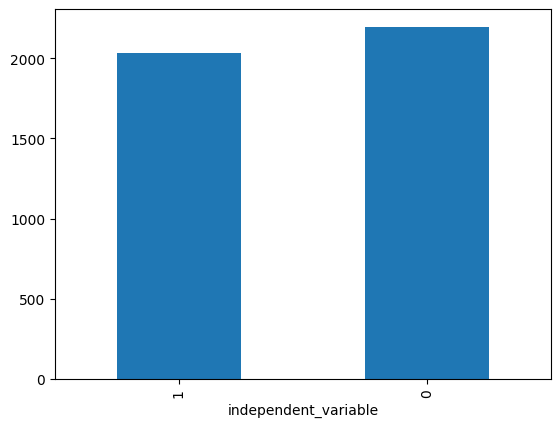

In [114]:
data_analysis.groupby('independent_variable').rt.mean().plot.bar()

In [ ]:
#自变量是被试的种族，分层变量是trait，因变量是
#自变量是是否为相同种族，分层变量是trait，因变量是rt
#是否要对面孔进行再次的筛选和编码、如何选取被试的ethnicity